### imports

In [1]:
import numpy as np
import pandas as pd

import os
from tqdm import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt

In [2]:
# ! pip3 install matplotlib

### prep labels

In [3]:
# get annotations file list
annotations_root = "embryoAI_labels"
annotations_file_list = os.listdir(annotations_root)

# get images file list
images_root = "embryoAI_images"
images_file_list = []
for path, subdir, files in os.walk(images_root):
    for file in files:
        if file.endswith(".jpeg"):
            images_file_list.append(os.path.join(path, file))

images = pd.DataFrame(images_file_list, columns=["path"])
images["case"] = images.path.str.split("/").str[1]
images["frame"] = images.path.str.split("RUN").str[-1].str[:-5].map(int)

In [4]:
# consolidate labels in one dataframe

def make_label_for_each_frame(annotations_file: str) -> pd.DataFrame:
    case = annotations_file.split("_")[0]
    case_annotations = pd.read_csv(os.path.join(annotations_root, annotations_file), 
                                   names = ["phase", "start", "end"])
    case_annotations["case"] = case
    case_annotations['frame']=[list(range(x,y+1)) for x, y in zip(case_annotations.start, case_annotations.end)]
    case_annotations_exploded = case_annotations.explode("frame").drop(columns=["start", "end"])
    return case_annotations_exploded[["case", "frame", "phase"]]

labels = pd.DataFrame()
for annotations_file in tqdm(annotations_file_list):
    labels = pd.concat([labels, make_label_for_each_frame(annotations_file)])
    
labels = labels.reset_index(drop=True)

100%|████████████████████████████████████████| 704/704 [00:02<00:00, 242.43it/s]


In [5]:
data = pd.merge(labels, images, on = ["case", "frame"], how = "left")

def add_reduced_labels(phase):
    if phase not in ['tB', 'tEB', 'tHB']:
        return "growing"
    elif phase == 'tB':
        return "blastocyst"
    elif phase == 'tEB':
        return "expanded"
    elif phase == 'tHB':
        return "hatched"
    else:
        return None
        

data["flag"] = data.phase.apply(add_reduced_labels)
data

,case,frame,phase,path,flag
0,DS61-1,9,tPB2,embryoAI_images/DS61-1/D2012.01.27_S0364_I132_...,growing
1,DS61-1,10,tPB2,embryoAI_images/DS61-1/D2012.01.27_S0364_I132_...,growing
2,DS61-1,11,tPB2,embryoAI_images/DS61-1/D2012.01.27_S0364_I132_...,growing
3,DS61-1,12,tPB2,embryoAI_images/DS61-1/D2012.01.27_S0364_I132_...,growing
4,DS61-1,13,tPB2,embryoAI_images/DS61-1/D2012.01.27_S0364_I132_...,growing
...,...,...,...,...,...
389264,RC755-9,472,tEB,embryoAI_images/RC755-9/D2013.07.08_S0875_I132...,expanded
389265,RC755-9,473,tEB,embryoAI_images/RC755-9/D2013.07.08_S0875_I132...,expanded
389266,RC755-9,474,tEB,embryoAI_images/RC755-9/D2013.07.08_S0875_I132...,expanded
389267,RC755-9,475,tEB,embryoAI_images/RC755-9/D2013.07.08_S0875_I132...,expanded


In [6]:
data = data.dropna().reset_index(drop = True)
data.to_csv("embryoAI_data.csv", index = False)

### exploratory analysis

In [7]:
reduced_counts = data.flag.value_counts()
reduced_counts

growing       344152
expanded       24699
blastocyst     13501
hatched           97
Name: flag, dtype: int64

<Axes: >

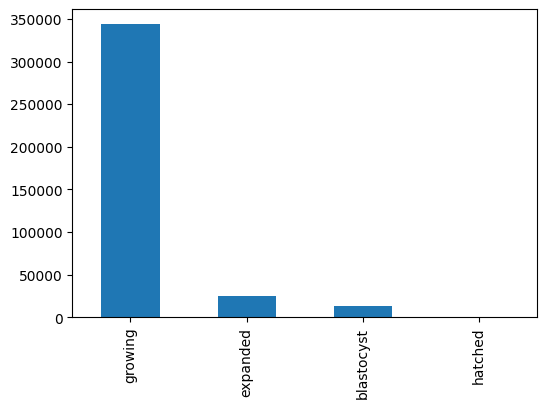

In [8]:
reduced_counts.plot(kind='bar', figsize = [6, 4])

In [9]:
counts = data.phase.value_counts(sort=False)
counts

tPB2    11596
tPNa    55541
tPNf     8778
t2      37819
t3       6442
t4      37929
t5      10156
t6      11027
t7      13659
tM      22174
tSB     22191
tB      13501
tEB     24699
t8      41587
t9+     65253
tHB        97
Name: phase, dtype: int64

<Axes: >

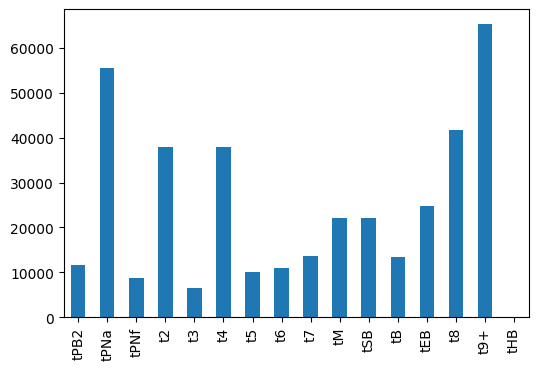

In [10]:
counts.plot(kind='bar', figsize = [6, 4])

In [11]:
unique_phases = data.groupby("case").nunique("frame")
unique_phases

,frame,phase,path,flag
case,,,,
AA83-7,281,10,281,1
AAL839-6,544,12,544,2
AB028-6,276,7,276,1
AB91-1,387,13,387,2
AC264-1,223,9,223,1
...,...,...,...,...
WS1048-4,420,14,420,3
WS531-4,419,12,419,3
ZL1077-1,345,12,345,3


In [12]:
unique_phases_frequency = unique_phases.phase.value_counts(sort=False).sort_index()
unique_phases_frequency

6      13
7      32
8      38
9      42
10     45
11     90
12     95
13    133
14    121
15     90
16      1
Name: phase, dtype: int64

<Axes: >

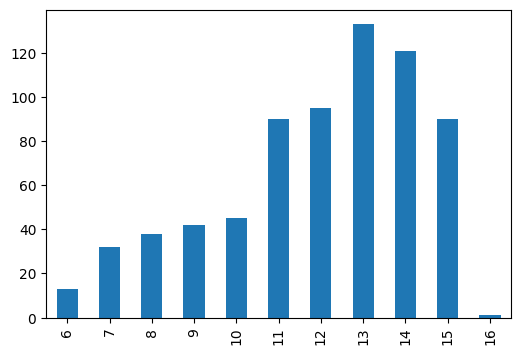

In [13]:
unique_phases_frequency.plot(kind="bar", figsize = [6, 4])

### splits

In [14]:
data = pd.read_csv("embryoAI_data.csv")

train = data.sample(frac=0.8)
val = train.sample(frac=0.2)
train = train[~train.isin(val).all(axis=1)]
test = data[~data.isin(train).all(axis=1)]

### make seperate image folders for splits

In [15]:
# def copy_file_to_folder(file_path, destination_folder):
#     # get the parent folder name
#     parent_folder = os.path.basename(os.path.dirname(file_path))

#     # create the destination folder with the parent folder name
#     destination_path = os.path.join(destination_folder, parent_folder)
#     if not os.path.exists(destination_path):
#         os.makedirs(destination_path)

#     # copy the file to the destination folder
#     shutil.copy(file_path, destination_path)

In [16]:
# train.path.progress_apply(lambda x: copy_file_to_folder(file_path = x, destination_folder = 'embryoAI_images_split/train_images'))

In [17]:
# val.path.progress_apply(lambda x: copy_file_to_folder(file_path = x, destination_folder = 'embryoAI_images_split/val_images'))

In [18]:
# test.path.progress_apply(lambda x: copy_file_to_folder(file_path = x, destination_folder = 'embryoAI_images_split/test_images'))

### save splits

In [19]:
train["path"] = train.path.str.replace("embryoAI_images/", "")
val["path"] = val.path.str.replace("embryoAI_images/", "")
test["path"] = test.path.str.replace("embryoAI_images/", "")

/var/folders/hg/twdjbc3s7kx2qkztrv70gx3r0000gn/T/ipykernel_40930/3922744642.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["path"] = test.path.str.replace("embryoAI_images/", "")


In [21]:
train.to_csv("embryoAI_train.csv", index = False)
val.to_csv("embryoAI_val.csv", index = False)
test.to_csv("embryoAI_test.csv", index = False)